In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms

### Creating the model

In [43]:
class BrainMRINet(nn.Module):
    # Define the model architecture
    def __init__(self):
        super(BrainMRINet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1) 
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.bn4 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 4)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    # Define the forward pass
    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.dropout(x)
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.dropout(x)
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 28 * 28)
        x = self.dropout(x)
        x = self.relu(self.bn4(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    
    # Define the training loop
    def fit(self, train_loader, val_loader, loss_function, optimizer, num_epochs=20, device='cuda', patience=4):
        train_losses = []
        val_losses = []
        val_accuracies = []
        best_accuracy = 0
        best_epoch = 0
        patience_counter = 0
        
        for epoch in range(num_epochs):
            self.train()
            running_loss = 0.0
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                
                optimizer.zero_grad()
                outputs = self(images)
                loss = loss_function(outputs, labels)
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()

            train_losses.append(running_loss/len(train_loader))
            
            # Validation
            self.eval()
            correct = 0
            total = 0
            val_running_loss = 0.0
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = self(images)
                    loss = loss_function(outputs, labels)
                    val_running_loss += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            val_loss = val_running_loss/len(val_loader)
            val_losses.append(val_loss)
            
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {running_loss/len(train_loader):.4f}, '
                f'Val Loss: {val_loss:.4f}, Validation Accuracy: {100 * correct / total:.2f}%')
            
            # Early stopping
            val_accuracy = 100 * correct / total
            val_accuracies.append(val_accuracy)

            if epoch > 0:
                if val_accuracy <= best_accuracy:
                    patience_counter += 1
                    if patience_counter >= patience:
                        print(f'Early stopping triggered after epoch {epoch+1}')
                        break
                else:
                    patience_counter = 0
                    best_accuracy = val_accuracy
                    best_epoch = epoch
            else:
                best_accuracy = val_accuracy
                patience_counter = 0

        print(f'Best accuracy: {best_accuracy:.2f} at epoch {best_epoch+1}')
                    
        return train_losses, val_losses, val_accuracies

### Loading the data

In [40]:
# Transforming the data to the right format
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = ImageFolder(root='../data/brain_mri', transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Loading training and validation data
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

### Training the model

In [44]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = BrainMRINet().to(device)

num_epochs = 20
patience = 4

# Choosing the loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses, val_losses, val_accuracies = model.fit(
    train_loader=train_loader,
    val_loader=val_loader,
    loss_function=loss_function,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    patience=patience
)

Using device: cuda
Epoch [1/20], Train Loss: 0.4688, Val Loss: 0.2958, Validation Accuracy: 89.32%
Epoch [2/20], Train Loss: 0.2413, Val Loss: 0.2390, Validation Accuracy: 91.46%
Epoch [3/20], Train Loss: 0.1279, Val Loss: 0.1454, Validation Accuracy: 95.23%
Epoch [4/20], Train Loss: 0.0881, Val Loss: 0.1663, Validation Accuracy: 94.45%
Epoch [5/20], Train Loss: 0.0499, Val Loss: 0.1396, Validation Accuracy: 96.09%
Epoch [6/20], Train Loss: 0.0273, Val Loss: 0.1821, Validation Accuracy: 94.59%
Epoch [7/20], Train Loss: 0.0181, Val Loss: 0.1302, Validation Accuracy: 96.30%
Epoch [8/20], Train Loss: 0.0236, Val Loss: 0.1792, Validation Accuracy: 94.66%
Epoch [9/20], Train Loss: 0.0222, Val Loss: 0.1553, Validation Accuracy: 95.59%
Epoch [10/20], Train Loss: 0.0222, Val Loss: 0.1900, Validation Accuracy: 95.16%
Epoch [11/20], Train Loss: 0.0255, Val Loss: 0.1484, Validation Accuracy: 96.23%
Early stopping triggered after epoch 11
Best accuracy: 96.30 at epoch 7


### Plotting the results

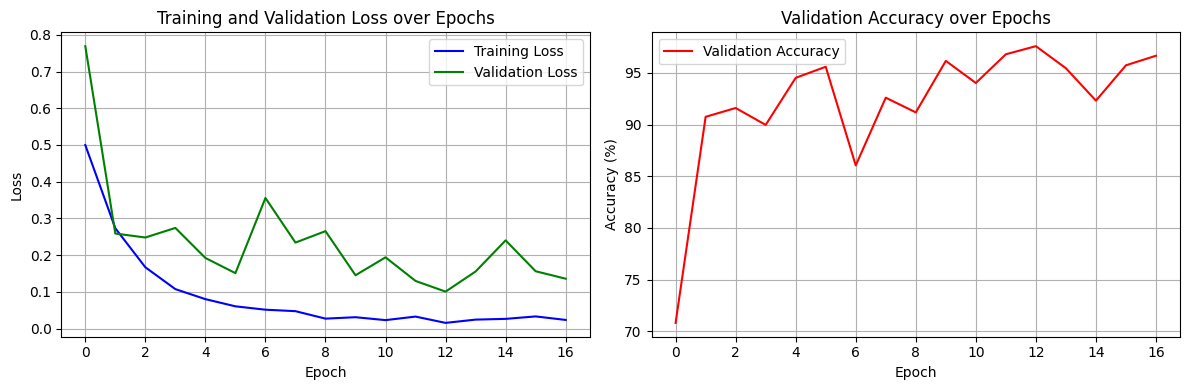

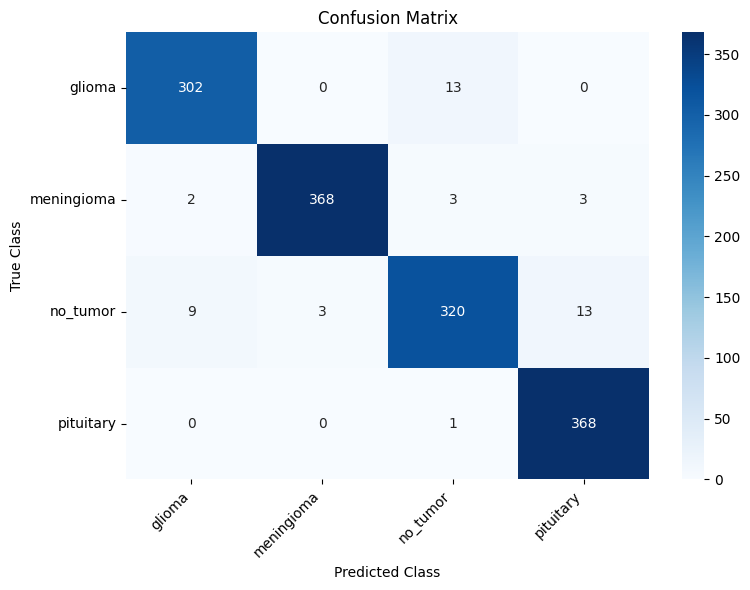

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

plt.figure(figsize=(12, 4))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, 'b-', label='Training Loss')
plt.plot(val_losses, 'g-', label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot validation accuracy 
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, 'r-', label='Validation Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Plot confusion matrix for validation set
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

class_names = ['glioma', 'meningioma', 'no_tumor', 'pituitary']

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.xticks(np.arange(len(class_names)) + 0.5, class_names, rotation=45, ha='right')
plt.yticks(np.arange(len(class_names)) + 0.5, class_names, rotation=0)
plt.tight_layout()
plt.show()